In [1]:
import splitfolders  # or import split_folders

# input_folder = '/mnt/c/Users/user/Desktop/Filtered'  # Path to your dataset
# output_folder = '/mnt/c/Users/user/Desktop/Fruit_Dataset'  # Path where the split datasets will be saved

# Split the dataset into train (80%), validation (10%), and test (10%)
# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils import class_weight


In [5]:
# Paths to datasets
data_train_path = '/mnt/c/Users/user/Desktop/Fruit_Dataset/train'
data_test_path = '/mnt/c/Users/user/Desktop/Fruit_Dataset/test'
data_val_path = '/mnt/c/Users/user/Desktop/Fruit_Dataset/val'

# Image dimensions and batch size (MobileNetV2 optimal size)
img_width, img_height = 224, 224
batch_size = 36

In [6]:
# Load datasets
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False
)

data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False
)


Found 7346 files belonging to 10 classes.
Found 1570 files belonging to 10 classes.
Found 1584 files belonging to 10 classes.


2025-03-31 15:41:44.145703: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-31 15:41:44.234447: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


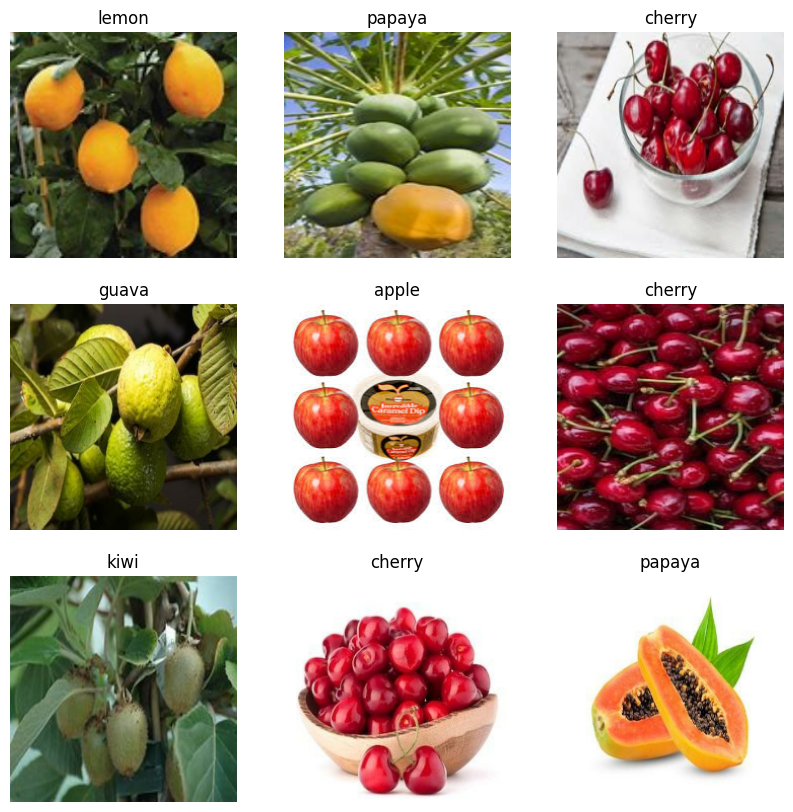

In [7]:
# Class names and weights
data_cat = data_train.class_names
class_counts = np.concatenate([y.numpy() for _, y in data_train], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(class_counts), y=class_counts)
class_weights = dict(enumerate(class_weights))

# Data visualization
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data_cat[labels[i]])
        plt.axis("off")
plt.show()


2025-03-31 15:41:47.655759: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


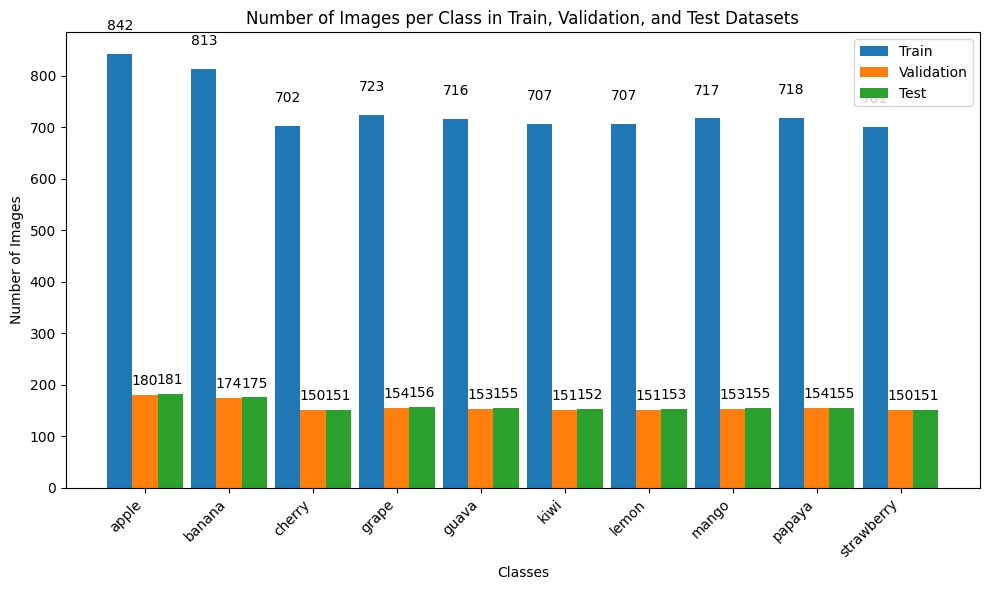

In [8]:


# Count the number of images in each class for the datasets
train_counts = [0] * len(data_cat)
val_counts = [0] * len(data_cat)
test_counts = [0] * len(data_cat)

# Count images for each class in data_train
for image_batch, label_batch in data_train:
    for label in label_batch.numpy():
        train_counts[label] += 1

# Count images for each class in data_val
for image_batch, label_batch in data_val:
    for label in label_batch.numpy():
        val_counts[label] += 1

# Count images for each class in data_test
for image_batch, label_batch in data_test:
    for label in label_batch.numpy():
        test_counts[label] += 1

# Plotting the bar graph
x = np.arange(len(data_cat))  # Class indices
width = 0.3  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each dataset (train, validation, test)
rects1 = ax.bar(x - width, train_counts, width, label='Train')
rects2 = ax.bar(x, val_counts, width, label='Validation')
rects3 = ax.bar(x + width, test_counts, width, label='Test')

# Labeling the plot
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class in Train, Validation, and Test Datasets')
ax.set_xticks(x)
ax.set_xticklabels(data_cat, rotation=45, ha="right")
ax.legend()

# Add total numbers of images on top of each bar with adjusted positions to prevent overlapping
for rect in rects1 + rects2 + rects3:
    height = rect.get_height()
    offset = 5  # Default offset
    # Adjust offset based on height of the bar to prevent overlap
    if height > 350:  # For large bars, increase offset
        offset = 15
    elif height > 700:  # For even larger bars, increase offset more
        offset = 15

    ax.annotate(f'{height}',
                xy=(rect.get_x() + rect.get_width() / 2, height),  # Positioning text above the bar
                xytext=(0, offset),  # Adjusting the offset dynamically
                textcoords="offset points",
                ha='center', va='bottom')  # 'bottom' ensures the text is above the bar

# Show the plot
plt.tight_layout()
plt.show()

In [9]:

# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1)
])

In [10]:
# Base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze initially

# Model architecture
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./127.5, offset=-1),  # MobileNet scaling
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.3),
    layers.Dense(len(data_cat), activation='softmax')
])

In [11]:
# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)


In [12]:
# Initial training
history = model.fit(
    data_train,
    validation_data=data_val,
    epochs=45,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/45
205/205 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.6569 - loss: 7.3511 - val_accuracy: 0.8809 - val_loss: 1.8506 - learning_rate: 0.0010
Epoch 2/45
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8387 - loss: 1.6709 - val_accuracy: 0.8796 - val_loss: 1.0283 - learning_rate: 0.0010
Epoch 3/45
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8452 - loss: 1.0597 - val_accuracy: 0.8669 - val_loss: 0.8611 - learning_rate: 0.0010
Epoch 4/45
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8480 - loss: 0.9096 - val_accuracy: 0.9032 - val_loss: 0.7139 - learning_rate: 0.0010
Epoch 5/45
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8511 - loss: 0.8622 - val_accuracy: 0.8777 - val_loss: 0.7613 - learning_rate: 0.0010
Epoch 6/45
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8387 - loss: 0.9061 - val_accuracy: 0.8688 - val_loss: 0.7816 - learning_rate: 0.0010
Epoch 7/45
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.8433 - l

In [13]:
# Evaluation
test_loss, test_acc = model.evaluate(data_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9003 - loss: 0.4582
Test Accuracy: 92.36%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


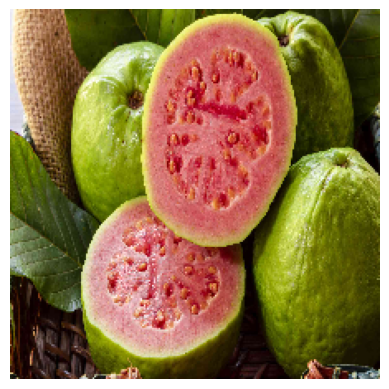

Fruit in image is guava


In [14]:

# Load and prepare the image
image_path = './test/Guava-15d1050d22034909bfca038ef1f8aaa2.jpg'
image = tf.keras.utils.load_img(image_path, target_size=(224, 224))  # Load image and resize
img_arr = tf.keras.utils.img_to_array(image)  # Convert to an array
img_bat = tf.expand_dims(img_arr, 0)  # Add batch dimension

# Make prediction
predict = model.predict(img_bat)  # Get model prediction
score = tf.nn.softmax(predict)  # Apply softmax to get class probabilities

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes for cleaner visualization
plt.show()  # Display the image

# Print the predicted class
print(f"Fruit in image is {data_cat[np.argmax(score)]}")

Text(0.5, 1.0, 'Loss')

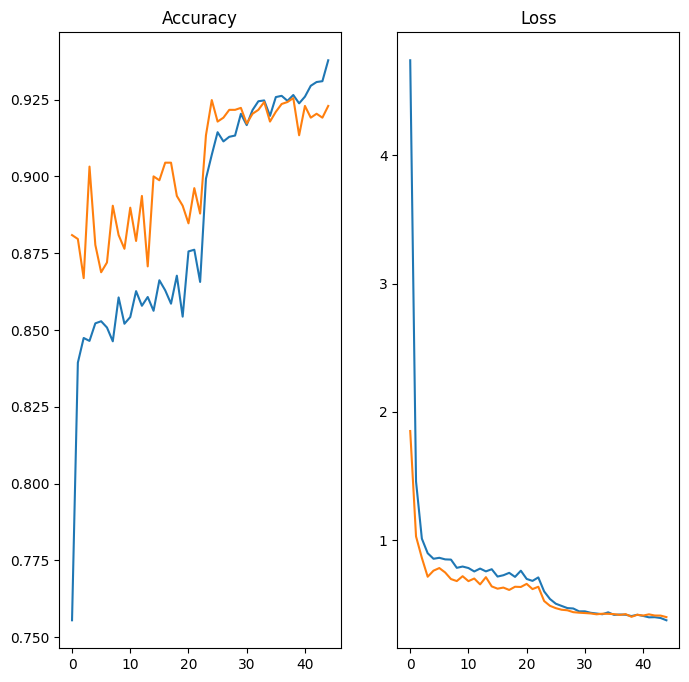

In [15]:
epochs_range = range(45)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')


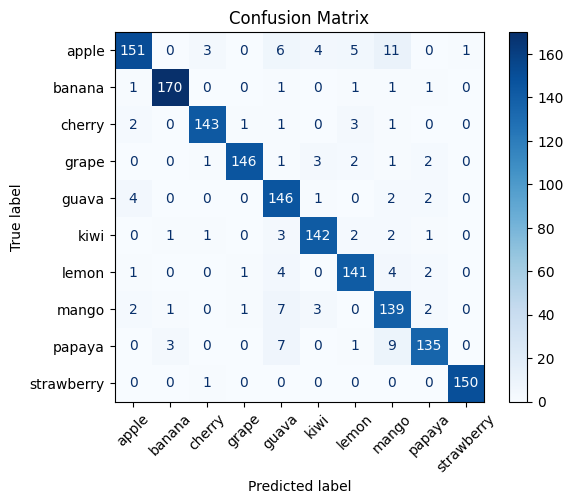

In [16]:
# Confusion Matrix
true_labels = []
pred_labels = []
for images, labels in data_test.unbatch():
    true_labels.append(labels.numpy())
    pred = model.predict(tf.expand_dims(images, 0), verbose=0)
    pred_labels.append(np.argmax(pred))

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_cat)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


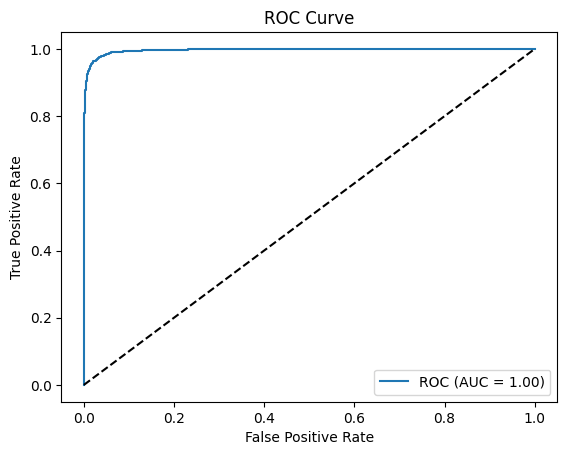

In [17]:
# ROC Curve
y_true = tf.keras.utils.to_categorical(true_labels, num_classes=len(data_cat))
y_pred = model.predict(data_test)
fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()